In [1]:
import numpy as np

from Code.Tutorial.algo_ssa import SSA
from Code.Tutorial.Dataset import load_scg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [2]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [3]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features

In [4]:
if __name__ == '__main__':
    signals_train, labels_train, duration, fs = load_scg(0.8, 'train')
    signals_test, labels_test, _, _ = load_scg(0.8, 'test')
    signals_clean, _, _, _ = load_scg(0, 'train')
    S_train, D_train = labels_train[:, -2], labels_train[:, -1]
    S_test, D_test = labels_test[:, -2], labels_test[:, -1]

In [8]:
def features_indexes(signals, L, trend2period, distance, show ):

    sampling_rate = fs
    idx = []
    features = []
    cnt = 0
    for i in tqdm(range(len(signals))):
        # print(i)
        # print(cnt)
        signal = signals[i]
        if max(signal) > 1:
            # print('ok')
            continue

        ssa_ = SSA(signal, L)

        ssa_signal = ssa_.reconstruct(slice(trend2period[cnt], L))
        peaks = get_peaks(ssa_signal, distance, duration, sampling_rate)

        if len(peaks) < 16:
            # print('ok')
            continue

        idx.append(i)
        # if cnt in [15, 23]:
        if show:

            # ssa_.calc_wcorr()
            ssa_.plot_wcorr(0, 35)
            # plt.savefig('./wcorr.jpg', dpi=300)
            plt.show()

            # plt.subplots(3, 1, figsize=(20, 12))
            #
            # plt.subplot(3, 1, 1)
            # ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            # ssa_.reconstruct(slice(0, trend2period[cnt])).plot(label='Noise Trend')
            # plt.title('Noisy Signal and its Trend')
            # plt.legend()
            #
            # plt.subplot(3, 1, 2)
            # ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
            # ssa_.reconstruct(slice(trend2period[cnt], L)).plot(label='Reconstructed Signal')
            # plt.title('Noisy Signal and Reconstructed Signal')
            #
            # plt.legend()
            #
            # plt.subplot(3, 1, 3)
            # plt.plot(signals_clean[i], label='Clean Signal')
            # ssa_.reconstruct(slice(trend2period[cnt], L)).plot(label='Reconstructed Signal')
            # plt.title('Clean Signal and Reconstructed Signal')
            # plt.legend()
            # # plt.savefig('./SSA_Effect.jpg', dpi=300)
            #
            # plt.show()

        features.append(get_features(ssa_signal, peaks))
        cnt += 1
        if i > 30:
            break
        # break
    return features, idx

L = 100
trend2period = 10
show = False

# features_train, idx_train = features_indexes(signals_train, L, trend2period, 15, show)
# features_test, idx_test = features_indexes(signals_test, L, trend2period, 10, show)
# trend2period_train = [10, 11, 12, 12, 10, 12, 11, 11, 12, 10, 10, 10, 10, 10, 10, 12, 10, 11, 12, 10, 12, 10, 11, 11, 10, 12, 11, 10, 12, 11, 11]
# print(len(trend2period_train))
# trend2period_test = [10, 10, 10, 9, 9, 10, 6, 10, 11, 11, 10, 10, 9, 9, 10, 11, 11, 11, 11, 10, 10, 12, 11, 11, 10, 10, 9, 10, 11, 10, 11]
# poses = [15, 23]
trend2period_test = [10, 10, 10, 9, 9, 10, 6, 10, 11, 11, 10, 10, 9, 9, 10, 6, 11, 11, 11, 10, 10, 12, 11, 6, 10, 10, 9, 10, 11, 10, 11]

# features_train_30, idx_30_train = features_indexes(signals_train, L, trend2period_train, 15, show=True)
# features_test_30, idx_30_test = features_indexes(signals_test, L, trend2period_test, 10, show=True)

trend2period_train = [4] * 31
features_train_30, idx_30_train = features_indexes(signals_train, L, trend2period_train, 15, show=False)
features_test_30, idx_30_test = features_indexes(signals_test, L, trend2period_test, 10, show=False)
features_train_30_np = np.array(features_train_30)
features_test_30_np = np.array(features_test_30)
idx_30_train_np = np.array(idx_30_train)
idx_30_test_np = np.array(idx_30_test)
#
idx_30_train_np.shape, features_test_30_np.shape

  1%|          | 31/3000 [00:23<36:46,  1.35it/s]


((31,), (31, 8))

In [9]:
# features_train_np = np.array(features_train)
# features_test_np = np.array(features_test)
# idx_train_np = np.array(idx_train)
# idx_test_np = np.array(idx_test)
#
# np.save('./features_train_0.8_5000.npz', features_train_np)
# np.save('./features_test_0.8_3000.npz', features_test_np)
# np.save('./idx_train_0.8_5000.npz', idx_train_np)
# np.save('./idx_test_0.8_3000.npz', idx_test_np)

features_train_np = np.load('../../Data/SSA/features_train_0.8_5000.npz.npy')
features_test_np = np.load('../../Data/SSA/features_test_0.8_3000.npz.npy')
idx_train = np.load('../../Data/SSA/idx_train_0.8_5000.npz.npy')
idx_test = np.load('../../Data/SSA/idx_test_0.8_3000.npz.npy')


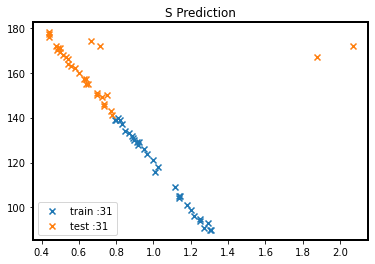

In [15]:
X, y = features_train_np[:, 3].reshape(-1, 1), S_train[idx_train]
X_test, y_test = features_test_np[:, 3], S_test[idx_test]
X_acc, y_acc = features_train_30_np[:, 3].reshape(-1, 1), S_train[idx_30_train_np]
X_test_acc, y_test_acc = features_test_30_np[:, 3].reshape(-1, 1), S_test[idx_30_test_np]
plt.figure()
idxex_start, idxex_end = 0, 8
# plt.scatter(X[31:], y[31:], label='train 31:')
plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# plt.scatter(X_acc[idxex_start: idxex_end], y_acc[idxex_start: idxex_end], label='accurate train :31')
# plt.scatter(X_test[31:], y_test[31:], label='test 31:')
# 24(worse), 16(better)
idxes = 31
plt.scatter(X_test[:idxes], y_test[:idxes], label='test :31', marker='x')
# plt.scatter(X_test_acc[:idxes], y_test_acc[:idxes], label='accurate test :31')
plt.legend()
plt.title('S Prediction')
plt.savefig('./auto_problems.jpg', dpi=300)
plt.show()

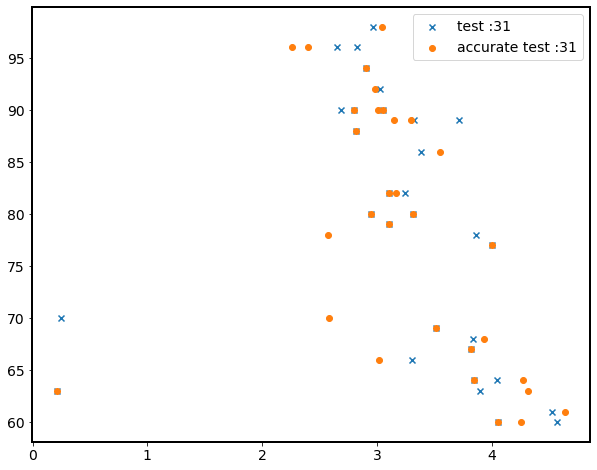

In [118]:
X, y = features_train_np[:, -1].reshape(-1, 1), D_train[idx_train]
X_test, y_test = features_test_np[:, -1], D_test[idx_test]
X_acc, y_acc = features_train_30_np[:, -1].reshape(-1, 1), D_train[idx_30_train_np]
X_test_acc, y_test_acc = features_test_30_np[:, -1].reshape(-1, 1), D_test[idx_30_test_np]
plt.figure()
# plt.scatter(X[31:], y[31:], label='train 31:')
# plt.scatter(X[:31], y[:31], label='train :31', marker='x')
# plt.scatter(X_acc, y_acc, label='accurate train :31')
# plt.scatter(X_test[31:], y_test[31:], label='test 31:')
plt.scatter(X_test[:31], y_test[:31], label='test :31', marker='x')
plt.scatter(X_test_acc, y_test_acc, label='accurate test :31')
plt.legend()
plt.show()

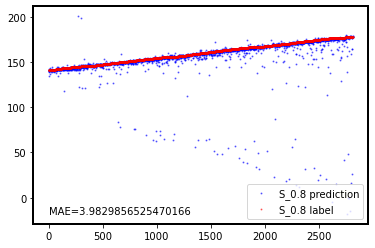

In [13]:
from sklearn.linear_model import LinearRegression as LR

reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
np.mean(np.abs(yhat - S_test[idx_test]))

from Code.Tutorial.utils import plot_2vectors
plot_2vectors( S_test[idx_test], yhat, False, 'S_0.8')

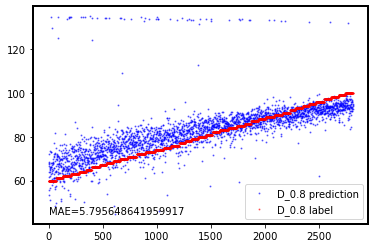

In [14]:
reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
np.mean(np.abs(yhat - D_test[idx_test]))

from Code.Tutorial.utils import plot_2vectors
plot_2vectors( D_test[idx_test], yhat, False, 'D_0.8')